In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import scipy.stats
import plotting_functions as pf
import analysis_functions as af
import sklearn
pf.set_fontsize(font_size=12)
%load_ext autoreload
%autoreload 2
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'


dr_legend = {'pca': 'PCA', 'rbm': 'RBM', 'fa': 'FA', 'ica': 'ICA', 'glm': 'GLM'}
dr_colors = {'glm': '#008B8B', 'pca': '#808000', 'rbm': '#800080', 'fa': 'red', 'ica':'#157bf9'}


Bad key "text.kerning_factor" on line 4 in
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/d

In [2]:
plt.rcParams['font.size']
import sklearn

In [3]:
# dict_reproducibility = af.load_reprod_matrix(swap=True, 
#                                              path='/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5/Reproducibility.txt')

# fig = plt.figure(constrained_layout=False, figsize=[15, 3])
# ax_sim = {}
# for i_plot, plot_name in enumerate(['RBM', 'covariance', 'correlation']):
#     ax_sim[i_plot] = plt.subplot(1, 3, 1 + i_plot)
#     pf.plot_reproduc_mat(dict_mat=dict_reproducibility, key=plot_name,
#                          ax=ax_sim[i_plot])
#     ax_sim[i_plot].set_title(f'Similarity {plot_name}', fontdict={'weight': 'bold'})

In [4]:
# dict_reproducibility = af.load_reprod_matrix(swap=True, 
#                                              path='/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5/Reproducibility.txt')

# fig = plt.figure(constrained_layout=False, figsize=[5, 4])
# pf.plot_reproduc_mat(dict_mat=dict_reproducibility, key='RBM',
#                      ax=fig.add_subplot())

## Jerome's fig;

In [3]:
## Takes up 8 GB RAM
version = '5'

env = pickle.load(open('/media/thijs/hooghoudt/connectivity_fig_data_jerome/connectivity_plot_files_v%s_no-neuron-connectivity.data'%version,'rb'))  # load light-weight version
# env = pickle.load(open('/media/thijs/hooghoudt/connectivity_fig_data_jerome/connectivity_plot_files_v%s.data'%version,'rb'))

runs = env['runs'] # List of experimental recordings used.
print(f'Loaded {len(runs)} runs')

# Baier matrices.
nRegions_baier = env['nRegions_baier'] # 72
assert nRegions_baier == 72
region_names_baier = env['region_names_baier'] # the region names, in the order displayed.

'''
There are various Baier matrices:
- his old version.
- his new version.
- the ones I rederived from his new data.
All viz are made with 'my_new_normalized_by_volume', but we can change at last stage if needed.
'''
selected_connectivity_type =  'his_old' #'my_new_normalized_by_volume'
connectivity_baier = env['connectivity_baier'] # The selected one. ( my_new_normalized .. )
all_baier_connectivities = env['all_baier_connectivities'] # All others.
connectivity_types = list(all_baier_connectivities.keys()) 

nNeurons_per_region = env['nNeurons_per_region'] # Number of neurons / region / recording.
mean_nNeurons_per_region = env['mean_nNeurons_per_region'] # Averaged number of neurons (across all recordings)

all_functional_connectivities = env['all_functional_connectivities']  # All functional connectivities inferred. For each run, each method, and each aggregation (L1 or L2 norm), one 72X72 matrix.
all_averaged_functional_connectivities = env['all_averaged_functional_connectivities'] # All functional connectivities inferred. For each run, each method, and each aggregation (L1 or L2 norm), one 72X72 matrix.
if 'all_neuron_connectivities' in env.keys():
    all_neuron_connectivities = env['all_neuron_connectivities']  # neuron to neuron connectivies, not present in light weight version 
methods = env['methods']
print(f'{methods} methods loaded')

averaging_weights = env['averaging_weights'] # The tensor of pair-weights used for producing the average functional connectivity (of size Nrecordings X Nregions X Nregions).
assert averaging_weights.ndim == 3

Loaded 8 runs
['RBM', 'covariance', 'correlation'] methods loaded


In [4]:
# region_names_baier  ## to write down abbreviation manually
# with open('/home/thijs/repos/zf-rbm/baier_atlas_labels/region_names_baier_abbreviations.txt', 'w') as f:
#     for name in region_names_baier:
#         f.write(name + '\n')

In [5]:
# # Save light-weight version
# new_env = {k: v for k, v in env.items() if k != 'all_neuron_connectivities'}  # recreate without neuron neuron connection to save space
# with open('/media/thijs/hooghoudt/connectivity_fig_data_jerome/connectivity_plot_files_v%s_no-neuron-connectivity.data'%version, 'wb') as f:
#     pickle.dump(new_env, f)

In [6]:
kunst_region_order = {}
kunst_region_order['inds'], kunst_region_order['names'], kunst_region_abbrev_trans = af.create_mapping_kunstea_order(current_regions=region_names_baier)
# kunst_region_order

In [7]:
aggregations = [1, 2]
selected_aggregation = 1 # Use L1 norm for the averaged.

# output_folder = '/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5_v4/'

'''
Determine "subset", the subset of regions onto which we perform analysis.
Here: At least 5 neurons on average for both the left and right region.
'''
Nmin = 5
subset = np.zeros(nRegions_baier, dtype='bool')
for i in range(nRegions_baier // 2):
    if (mean_nNeurons_per_region[2 * i] >= Nmin) & (mean_nNeurons_per_region[2 * i + 1] >= Nmin):  # left & right
        subset[2 * i] = 1
        subset[2 * i + 1] = 1
subset = np.nonzero(subset)[0]

'''
Determine the recording-level subset of regions. Useful for pairwise comparison and recording visualization.
'''
nNeurons_per_region_symmetrical = np.concatenate([np.concatenate([nNeurons_per_region[2*i+1:2*i+2,:],
                                                                  nNeurons_per_region[2*i:2*i+1]], axis=0) for i in range(nRegions_baier//2)], axis=0)  # size n_regions x n_fish
relevant_regions = np.zeros(nNeurons_per_region.shape, dtype=bool)  # shape n_regions x n_fish
relevant_regions[subset,:] = (nNeurons_per_region[subset, :] >= Nmin) & (nNeurons_per_region_symmetrical[subset, :] >= Nmin)
relevant_regions2 = relevant_regions[:, np.newaxis] * relevant_regions[np.newaxis, :, :]    # shape n_regions x n_regions x n_fish
nRuns = len(runs)    
all_masks = relevant_regions2.reshape([nRegions_baier ** 2, nRuns]).T 

top_triangle = np.triu_indices_from(relevant_regions2[:, :, 0], k=1)  # including diag, so skip diag
relevant_regions_triangle = relevant_regions2.copy()
for i_fish in range(relevant_regions2.shape[2]):
    tmp = relevant_regions2[:, :, i_fish].copy()
    tmp[top_triangle] = False
    relevant_regions_triangle[:, :, i_fish] = tmp.copy()
all_masks_triangle = relevant_regions_triangle.reshape([nRegions_baier ** 2, nRuns]).T 

In [8]:
# plt.imshow(relevant_regions_triangle[:, :, 3])
all_masks_triangle.sum()

7612

In [9]:
## show single dataset heatmaps
# all_spearman = {}
# all_pearson = {}
# all_spearman_averaged = {}
# all_pearson_averaged = {}
connectivity_key_format = 'run:{run}_method:{method}_agg:{aggregation}'
correlation_key_format = 'run:{run}_method:{method}_agg:{aggregation}_conn:{connectivity_type}'
averaged_connectivity_key_format = 'method:{method}_agg:{aggregation}'
correlation_averaged_connectivity_key_format = 'method:{method}_agg:{aggregation}_conn:{connectivity_type}'

## Compute spearman and pearson correlation between each functional connectivity set & Baier.
# for k, run in enumerate(runs):
#     for method in methods:
#         for aggregation in aggregations:
#             key_dict = connectivity_key_format.format(
#                 run=run, method=method, aggregation=aggregation)
#             prediction = all_functional_connectivities[key_dict].copy()  # use individual connectivity
#             for connectivity_type in connectivity_types:
#                 target = all_baier_connectivities[connectivity_type].copy()
#                 if connectivity_type in ['his_old', 'his_new']:
#                     target[np.arange(len(target)), np.arange(
#                         len(target))] += 1.0 * target.max()  # They did not define a diagonal connexion (intra-region connectivity). Set to the maximum value across all entry.

#                 flat_target = target.flatten()[all_masks[k]] # Baier connectivity of non-zero regions
#                 flat_prediction = prediction.flatten()[all_masks[k]] # Functional connectivity of non-zero regions
#                 # flat_target = target[subset, :][:, subset].flatten()
#                 # flat_prediction = prediction[subset,
#                 #                              :][:, subset].flatten()
#                 spearman = scipy.stats.spearmanr(
#                     flat_target, flat_prediction).correlation  # compute correlations
#                 pearson = np.corrcoef(
#                     flat_target, flat_prediction)[0, 1]

#                 key = correlation_key_format.format(
#                     run=run, method=method, aggregation=aggregation, connectivity_type=connectivity_type)
#                 all_spearman[key] = spearman
#                 all_pearson[key] = pearson

## Compute average spearman and pearson correlation.
## (essentially just the run loop is missing here)
# for connectivity_type in connectivity_types:
#     for method in methods:
#         for aggregation in aggregations:
#             prediction = all_averaged_functional_connectivities[averaged_connectivity_key_format.format(
#                 method=method, aggregation=aggregation)]  # use averaged connectivity (across fish)
#             target = all_baier_connectivities[connectivity_type].copy()
#             if connectivity_type in ['his_old', 'his_new']:
#                 target[np.arange(len(target)), np.arange(
#                     len(target))] += 1.0 * target.max()

#             flat_target = target[subset, :][:, subset].flatten()
#             flat_prediction = prediction[subset,
#                                          :][:, subset].flatten()

#             spearman = scipy.stats.spearmanr(
#                 flat_target, flat_prediction).correlation
#             pearson = np.corrcoef(flat_target, flat_prediction)[0, 1]

#             key = correlation_averaged_connectivity_key_format.format(
#                 method=method, aggregation=aggregation,connectivity_type=connectivity_type)
#             all_spearman_averaged[key] = spearman
#             all_pearson_averaged[key] = pearson

# Make region filters.
all_correlations = {}   
for method in methods:
    correlation = np.zeros([nRuns, nRuns])
    p_vals = np.zeros_like(correlation)
    for k1, run1 in enumerate(runs):
        for k2, run2 in enumerate(runs):
            key1 = 'run:%s_method:%s_agg:%s'%(run1,method, selected_aggregation)
            key2 = 'run:%s_method:%s_agg:%s'%(run2,method, selected_aggregation)
            connections1 = all_functional_connectivities[key1].flatten()
            connections2 = all_functional_connectivities[key2].flatten()
            mask = all_masks_triangle[k1, :] & all_masks_triangle[k2, :]
#             correlation[k1,k2] = np.corrcoef(connections1[mask],connections2[mask])[0,1]   
            correlation[k1, k2], p_vals[k1, k2] = scipy.stats.pearsonr(np.log10(connections1[mask]),
                                                                       np.log10(connections2[mask]))
            # correlation[k1,k2] = (connections1[mask]*connections2[mask]).mean()/np.sqrt( (connections1[mask]**2).mean() * (connections2[mask]**2).mean() )
    all_correlations[method] = {'pearson': correlation, 'run_names': runs, 
                                'p_vals_pearson': p_vals}

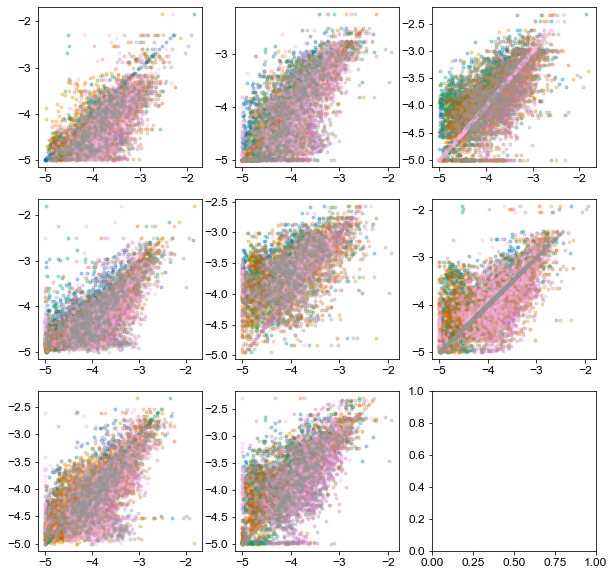

In [8]:
# fig, ax = plt.subplots(nRuns, nRuns, figsize=[20, 20])
fig, ax = plt.subplots(3, 3, figsize=[10, 10])
method = 'RBM'
aggregation = 1
all_connections_tensor = np.zeros((72, 72, len(runs)))
all_connections_array = np.array([])
correlation = np.zeros([nRuns,nRuns])
for k1, run1 in enumerate(runs):
    i_row = k1 % 3
    i_col = int(np.floor(k1 / 3))
    
    for k2, run2 in enumerate(runs):
        key1 = 'run:%s_method:%s_agg:%s'%(run1, method, selected_aggregation)
        key2 = 'run:%s_method:%s_agg:%s'%(run2, method, selected_aggregation)
        connections1 = all_functional_connectivities[key1].flatten()
        connections2 = all_functional_connectivities[key2].flatten()
        mask = all_masks_triangle[k1] & all_masks_triangle[k2]  # mutual masks
        ax[i_row][i_col].plot(np.log10(connections2[mask] + 1e-5), 
                              np.log10(connections1[mask] + 1e-5), '.', alpha=0.3)

    ## use only one trianlge
    tri_inds = np.triu_indices_from(all_functional_connectivities[key1], k=0)
    connections_triangle = all_functional_connectivities[key1][tri_inds]
    all_connections_array = np.concatenate((all_connections_array, connections_triangle))
    all_connections_tensor[:, :, k1] = all_functional_connectivities[key1]

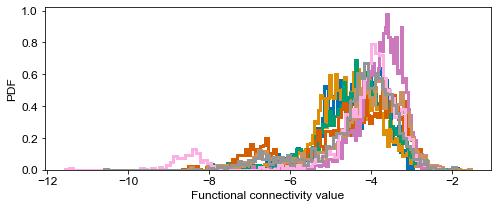

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
for i_fish in range(len(runs)):
    tmp_dens = all_connections_tensor[: ,:, i_fish]
    ax.hist(np.log10(tmp_dens[tmp_dens > 0]), bins=100, density=True, histtype='step', linewidth=3);
ax.set_xlabel('Functional connectivity value');
ax.set_ylabel('PDF');

9345 21024
RBM 3219 5184
covariance 3219 5184
correlation 3219 5184


(-10, -2)

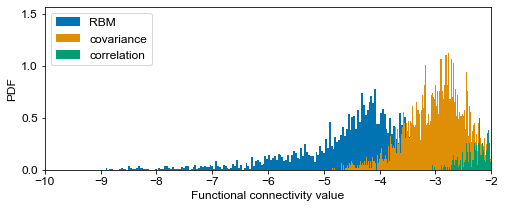

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
# ax.hist(np.sqrt(all_connections_array[all_connections_array > 0]), bins=200, density=True);
ax.set_xlabel('Functional connectivity value');
ax.set_ylabel('PDF');
print(len(all_connections_array[all_connections_array > 0]), len(all_connections_array))

for method in methods:
    tmp_dens = all_averaged_functional_connectivities[f'method:{method}_agg:1'].ravel()
    ax.hist(np.log10(tmp_dens[tmp_dens > 0]), bins=200, density=True, label=method);
    print(method, len(tmp_dens[tmp_dens > 0]), len(tmp_dens))
ax.legend()
ax.set_xlim([-10, -2])

Text(0.5, 1.0, 'correlation')

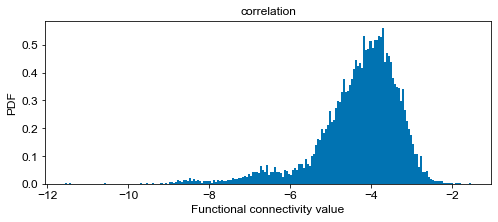

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.hist(np.log10(all_connections_array[all_connections_array > 0]), bins=200, density=True);
ax.set_xlabel('Functional connectivity value');
ax.set_ylabel('PDF');
ax.set_title('correlation')

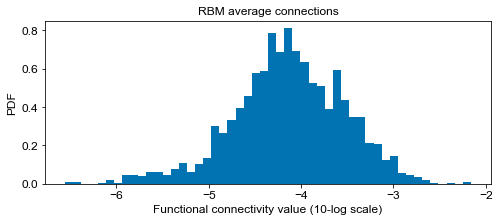

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.hist(np.log10(all_averaged_functional_connectivities['method:RBM_agg:1'][subset, :][:, subset]).flatten(), bins=50, density=True);
ax.set_xlabel('Functional connectivity value (10-log scale)');
ax.set_ylabel('PDF');
ax.set_title('RBM average connections');

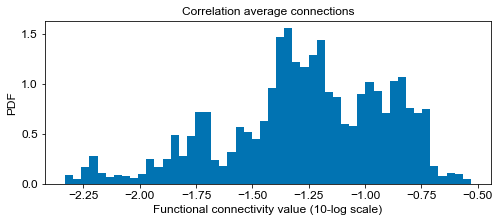

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.hist(np.log10(all_averaged_functional_connectivities['method:correlation_agg:1'][subset, :][:, subset]).flatten(), bins=50, density=True);
ax.set_xlabel('Functional connectivity value (10-log scale)');
ax.set_ylabel('PDF');
ax.set_title('Correlation average connections');

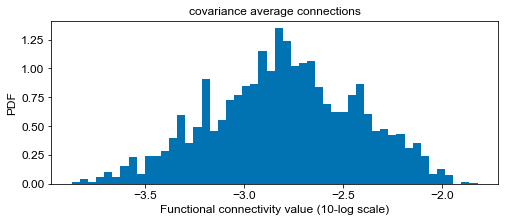

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.hist(np.log10(all_averaged_functional_connectivities['method:covariance_agg:1'][subset, :][:, subset]).flatten(), bins=50, density=True);
ax.set_xlabel('Functional connectivity value (10-log scale)');
ax.set_ylabel('PDF');
ax.set_title('covariance average connections');

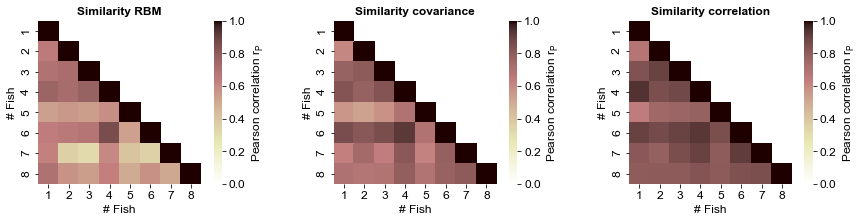

In [17]:
fig = plt.figure(constrained_layout=False, figsize=[15, 3])
ax_sim = {}
for i_plot, plot_name in enumerate(['RBM', 'covariance', 'correlation']):
    ax_sim[i_plot] = plt.subplot(1, 3, 1 + i_plot)
    pf.plot_reproduc_mat(dict_mat=all_correlations, key=plot_name,
                         ax=ax_sim[i_plot])
    ax_sim[i_plot].set_title(f'Similarity {plot_name}', fontdict={'weight': 'bold'})

In [15]:
all_correlations['RBM']['p_vals_pearson'].max()


5.700557789593336e-21

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


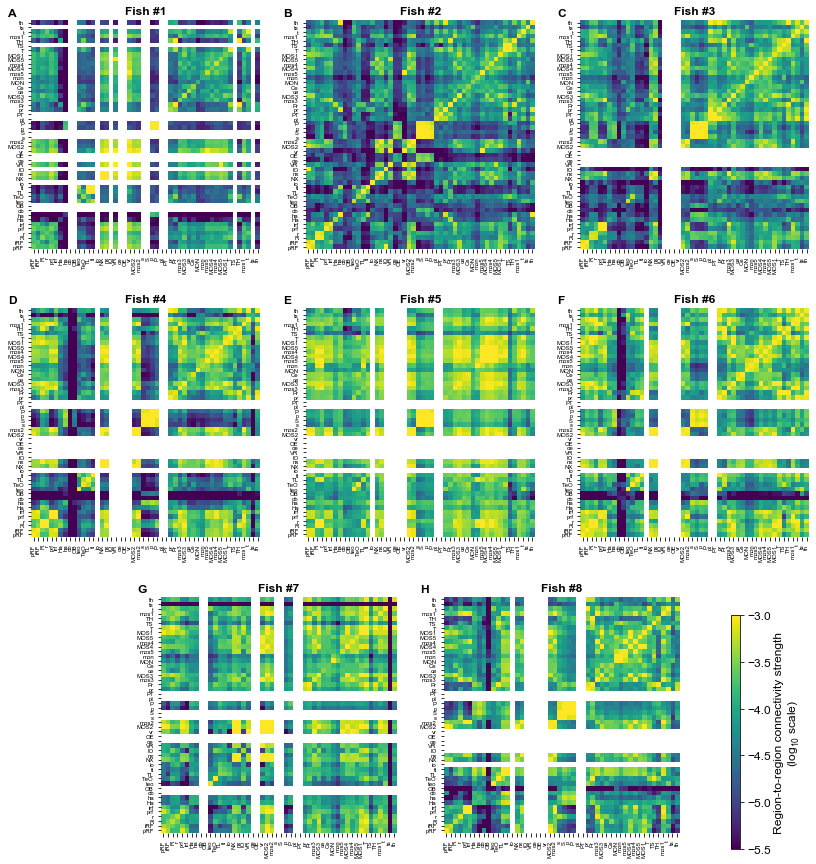

In [23]:
nRuns = len(runs)    
assert runs == all_correlations['RBM']['run_names']
save_fig = False
method = 'RBM'

fig = plt.figure(constrained_layout=False, figsize=[12, 12])
gs_middle_top = fig.add_gridspec(ncols=3, nrows=2, bottom=0.35, top=1, 
                             hspace=0.05, wspace=0.2, left=0.05, right=0.95)
gs_bottom = fig.add_gridspec(ncols=2, nrows=1, bottom=0.02, top=0.32, 
                             hspace=0.05, wspace=0.2, left=0.2, right=0.8)
gs_cbar = fig.add_gridspec(ncols=1, nrows=1, bottom=0.015, top=0.285, 
                             hspace=0.05, wspace=0.2, left=0.86, right=0.87)
cax=plt.subplot(gs_cbar[0])
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
ncols = 3
for k, run in enumerate(runs):
    i = k // ncols
    j = k % ncols
    if i <= 1:
        ax_current = plt.subplot(gs_middle_top[i, j])
    else:
        ax_current = plt.subplot(gs_bottom[j])
    index_run = np.where(np.array(all_correlations['RBM']['run_names']) == run)[0]
    assert len(index_run) == 1
    key_matrix = connectivity_key_format.format(
        run=run, method=method, aggregation=selected_aggregation)
    key_correlation = correlation_key_format.format(
        run=run, method=method, aggregation=selected_aggregation, connectivity_type=selected_connectivity_type)
    prediction = all_functional_connectivities[key_matrix]
    prediction_ = prediction.copy()
    prediction_[~all_masks[index_run].reshape([nRegions_baier,nRegions_baier])] = np.nan  # add nans for empty regions

#     spearman = all_spearman[key_correlation]  # precomputed correlatoin with Baier 
#     pearson = all_pearson[key_correlation]
    ax_current, _ = pf.plot_connectivity_matrix(prediction_, region_names_baier, mini=-5.5, maxi=-3,
                                size=5, ax=ax_current, subset=subset, plot_log=True, scale_limits=True,
                                region_order_dict=kunst_region_order, plot_labels=True,
                                          fill_nans_with_min=False, cbar=(k == 7), cax=cax)
    ax_current.set_title(f'Fish #{index_run[0] + 1}', fontdict={'weight': 'bold'})
    ax_current.text(s=label_list[k], x=54.5, y=-1.5, fontdict={'weight': 'bold', 'size': 12})

plt.tight_layout()
if save_fig:
    fig.savefig('/home/thijs/repos/zf-rbm/figures/sfig_connectivity_all_individuals.pdf', dpi=300, bbox_to_inches='tight')


In [24]:
for i_run, run in enumerate(runs):
    print(f'{i_run + 1}: {run}')

1: 20180706_Run04
2: 20180911_Run01
3: 20180912_Run01
4: 20180913_Run01
5: 20190109_Run04
6: 20181206_Run03
7: 20190102_Run01
8: 20181206_Run05


-3.7172038891484274 0.14327532717039834
[ 0.50633501 -4.04073764  0.74095536]
P value density log normal:  NormaltestResult(statistic=56.16857748907521, pvalue=6.355480200312076e-13)
3.834346773993575
7.277299333448464e-05 1.319772643823626e-05
[2.92181824e+02 7.27729933e-05 1.31977264e-05]
P value density normal:  NormaltestResult(statistic=424.59615541159303, pvalue=6.311263805614051e-93)
0.12576500050212913


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int

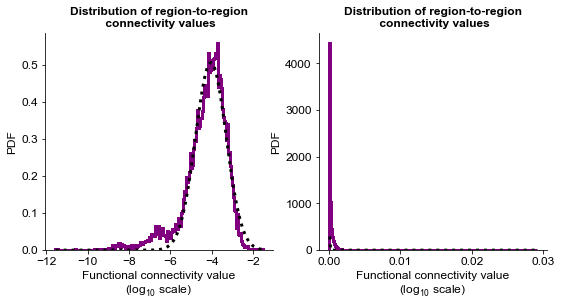

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax_dens = ax[0]
dens_freq, dens_bins, _ = ax_dens.hist(np.log10(all_connections_array[all_connections_array > 0]), # all_connections_array uses only 1 triangle of matrix
                       bins=200, density=True, histtype='step', linewidth=3, color=dr_colors['rbm']);
dens_plot_bins = (dens_bins[1:] + dens_bins[:-1]) / 2


popt, pcov = af.fit_gaussian(dens_plot_bins, dens_freq)
ax_dens.plot(dens_plot_bins, af.gaus(dens_plot_bins, *popt), linestyle=':', c='k', zorder=1, linewidth=3)
print('P value density log normal: ', scipy.stats.normaltest(dens_freq))
ax_dens.set_xlabel('Functional connectivity value\n(' + r"$\mathregular{log_{10}}$" + ' scale)');
ax_dens.set_ylabel('PDF');
ax_dens.spines['top'].set_visible(False)
ax_dens.spines['right'].set_visible(False)
ax_dens.set_title('Distribution of region-to-region\n connectivity values', 
                  fontdict={'weight': 'bold'})
print(sklearn.metrics.mutual_info_score(dens_freq, af.gaus(dens_plot_bins, *popt)))

ax_dens = ax[1]
dens_freq, dens_bins, _ = ax_dens.hist(all_connections_array[all_connections_array > 0], # all_connections_array uses only 1 triangle of matrix
                       bins=200, density=True, histtype='step', linewidth=3, color=dr_colors['rbm']);
dens_plot_bins = (dens_bins[1:] + dens_bins[:-1]) / 2


popt, pcov = af.fit_gaussian(dens_plot_bins, dens_freq)
ax_dens.plot(dens_plot_bins, af.gaus(dens_plot_bins, *popt), linestyle=':', c='k', zorder=1, linewidth=3)
print('P value density normal: ', scipy.stats.normaltest(dens_freq))
ax_dens.set_xlabel('Functional connectivity value\n(' + r"$\mathregular{log_{10}}$" + ' scale)');
ax_dens.set_ylabel('PDF');
ax_dens.spines['top'].set_visible(False)
ax_dens.spines['right'].set_visible(False)
ax_dens.set_title('Distribution of region-to-region\n connectivity values', 
                  fontdict={'weight': 'bold'})
print(sklearn.metrics.mutual_info_score(dens_freq, af.gaus(dens_plot_bins, *popt)))

-3.7172038891484274 0.14327532717039834
[ 0.50633501 -4.04073764  0.74095536]
P value density log normal:  NormaltestResult(statistic=56.16857748907521, pvalue=6.355480200312076e-13)


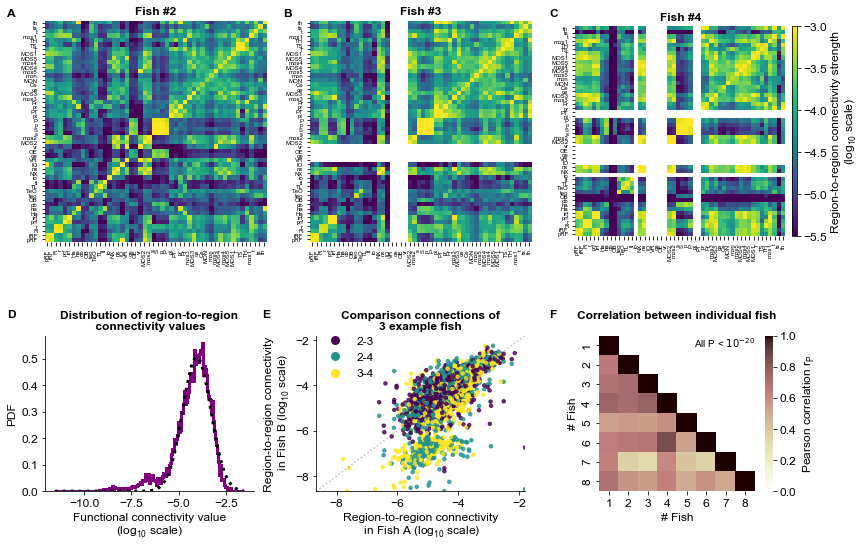

In [19]:
plot_runs = ['20180911_Run01', '20180912_Run01', '20180913_Run01']
save_fig = False
selected_connectivity_type = 'my_new_normalized_by_volume'


fig = plt.figure(constrained_layout=False, figsize=[12, 8])
gs_matrix = fig.add_gridspec(ncols=3, nrows=1, bottom=0.5, top=0.95, 
                             hspace=0.1, wspace=0.2, left=0.05, right=0.92)
gs_stats = fig.add_gridspec(ncols=3, nrows=1, bottom=0.1, top=0.37, 
                             hspace=0.1, wspace=0.3, left=0.05, right=0.92)

ax_mat = {}

for k, run in enumerate(plot_runs):
    ax_mat[k] = fig.add_subplot(gs_matrix[k])
    index_run = np.where(np.array(all_correlations['RBM']['run_names']) == run)[0]
    assert len(index_run) == 1
    key_matrix = connectivity_key_format.format(
        run=run, method='RBM', aggregation=1)
    key_correlation = correlation_key_format.format(
        run=run, method='RBM', aggregation=1, connectivity_type=selected_connectivity_type)
    prediction = all_functional_connectivities[key_matrix]
    prediction_ = prediction.copy()
    prediction_[~all_masks[index_run].reshape([nRegions_baier,nRegions_baier])] = np.nan  # add nans for empty regions

#     spearman = all_spearman[key_correlation]  # precomputed correlatoin with Baier 
#     pearson = all_pearson[key_correlation]
    if k == 2:
        plot_cbar = True
    else:
        plot_cbar = False
    ax_mat[k], _ = pf.plot_connectivity_matrix(prediction_, region_names_baier, mini=-5.5, maxi=-3,
                                            cmap='viridis',
                                            size=5, ax=ax_mat[k], subset=subset, plot_log=True, scale_limits=True,
                                            region_order_dict=kunst_region_order, plot_labels=True,
                                            cbar=plot_cbar, fill_nans_with_min=False)
#     ax_mat[k].set_title('Fish #%s , Spearman = %.3f, Pearson = %.3f' % (
#         index_run[0] + 1, spearman, pearson), fontsize=12, fontdict={'weight': 'bold'})
#     ax_mat[k].set_title(run, fontsize=12, fontdict={'weight': 'bold'})
    ax_mat[k].set_title(f'Fish #{index_run[0] + 1}', fontdict={'weight': 'bold'})


ax_dens = fig.add_subplot(gs_stats[0])
dens_freq, dens_bins, _ = ax_dens.hist(np.log10(all_connections_array[all_connections_array > 0]), # all_connections_array uses only 1 triangle of matrix
                       bins=200, density=True, histtype='step', linewidth=3, color=dr_colors['rbm']);
dens_plot_bins = (dens_bins[1:] + dens_bins[:-1]) / 2


popt, pcov = af.fit_gaussian(dens_plot_bins, dens_freq)
ax_dens.plot(dens_plot_bins, af.gaus(dens_plot_bins, *popt), linestyle=':', c='k', zorder=1, linewidth=3)
print('P value density log normal: ', scipy.stats.normaltest(dens_freq))
ax_dens.set_xlabel('Functional connectivity value\n(' + r"$\mathregular{log_{10}}$" + ' scale)');
ax_dens.set_ylabel('PDF');
ax_dens.spines['top'].set_visible(False)
ax_dens.spines['right'].set_visible(False)
ax_dens.set_title('Distribution of region-to-region\n connectivity values', 
                  fontdict={'weight': 'bold'})

ax_scatter = fig.add_subplot(gs_stats[1])
pf.plot_multi_fish_connectivity_scatter(all_connections_tensor=all_connections_tensor, 
                                        fish_combinations=[(1, 2), (1, 3), (2, 3)],
                                        axis_lim=None,#[-6, -1.5],
                                        ax=ax_scatter)
ax_scatter.set_title('Comparison connections of\n3 example fish', fontdict={'weight': 'bold'})

ax_corr = fig.add_subplot(gs_stats[2])
pf.plot_reproduc_mat(dict_mat=all_correlations, key='RBM',
                 ax=ax_corr)
ax_corr.set_title('Correlation between individual fish\n', 
                  fontdict={'weight': 'bold'});
sci_not = np.format_float_scientific(all_correlations['RBM']['p_vals_pearson'].max(), precision=3)  # highest P value
sci_exp_ceil = int(sci_not.split('e')[1]) + 1  # round up
ax_corr.text(s='All P < ' + r"$10^{{{tmp}}}$".format(tmp=sci_exp_ceil), x=8, y=0, fontdict={'ha': 'right', 'va': 'top'})

ax_mat[0].text(s='A', x=58, y=-1.5, fontdict={'weight': 'bold', 'size': 12})
ax_mat[0].text(s='B', x=-4.4, y=-1.5, fontdict={'weight': 'bold', 'size': 12})
ax_mat[0].text(s='C', x=-64.5, y=-1.5, fontdict={'weight': 'bold', 'size': 12})
ax_mat[0].text(s='D', x=58, y=66.7, fontdict={'weight': 'bold', 'size': 12})
ax_mat[0].text(s='E', x=0.4, y=66.7, fontdict={'weight': 'bold', 'size': 12})
ax_mat[0].text(s='F', x=-64.5, y=66.7, fontdict={'weight': 'bold', 'size': 12})
if save_fig:
    fig.savefig('/home/thijs/repos/zf-rbm/figures/fig_connectivity_individuals.pdf', dpi=300)


In [36]:
print(all_correlations['RBM']['p_vals_pearson'].max())
sci_not = np.format_float_scientific(all_correlations['RBM']['p_vals_pearson'].max(), precision=3)
sci_exp_ceil = int(sci_not.split('e')[1]) + 1

5.700557789593336e-21


In [37]:
tmp = all_correlations['RBM']['pearson']
tmp_tri_inds = np.triu_indices_from(tmp, k=0)
np.mean(tmp[tmp_tri_inds])

0.6859917196350294

In [38]:
runs

['20180706_Run04',
 '20180911_Run01',
 '20180912_Run01',
 '20180913_Run01',
 '20190109_Run04',
 '20181206_Run03',
 '20190102_Run01',
 '20181206_Run05']

before zero filtering  (1275,)
after zero filtering  (697,)
RBM Pearson: 0.42493924604422584 , Spearman:  0.394726228503694
2.0862602548188084e-27
578 zero and 697 non-zero structural connections
KstestResult(statistic=0.45265423242467717, pvalue=1.199424916199801e-59)
(0.4526542324246771, 1.8447277693643593e-57, 315.97333333333336)
-3.557656221567462 0.07984766309061431
[ 0.75949135 -3.83791717  0.52925465]
-4.312243269099914 0.07400006638073521
[ 0.83547515 -4.39078224  0.45124626]


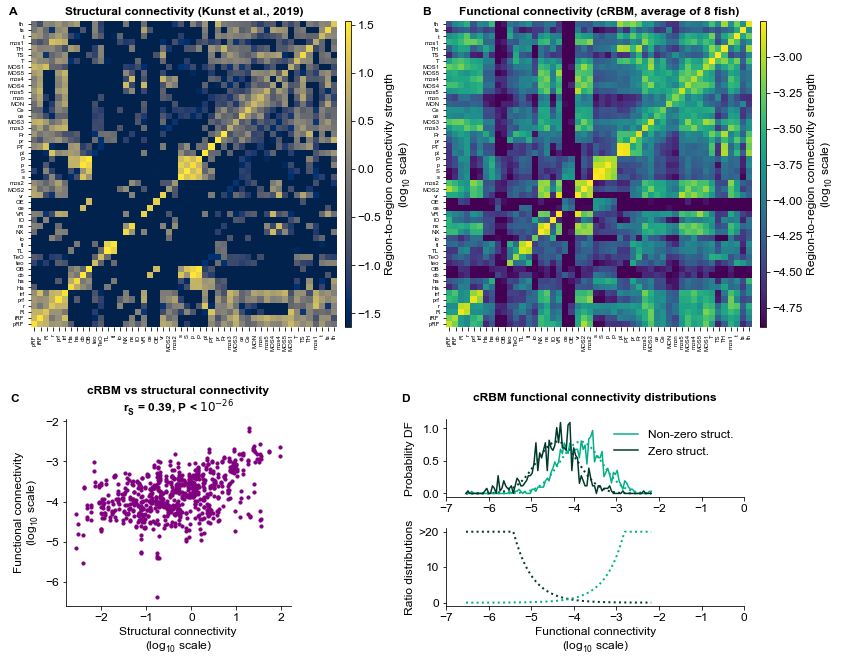

In [35]:
save_fig = True
selected_connectivity_type = 'my_new_normalized_by_volume'

fig = plt.figure(figsize=[12, 10]) # 12, 9 with 3 spearmans
gs_matrices = fig.add_gridspec(ncols=2, nrows=1, left=0.05, right=0.9, top=0.95,
                               bottom=0.45, wspace=0.3, hspace=0)
# gs_bottom = fig.add_gridspec(ncols=3, nrows=1, left=0.1, right=0.9, top=0.32, bottom=0.1,
#                              wspace=0.7)
gs_bottom_left = fig.add_gridspec(ncols=1, nrows=1, left=0.09, right=0.35, top=0.36, bottom=0.1,
                             wspace=0.7)
gs_bottom_right = fig.add_gridspec(ncols=1, nrows=2, left=0.53, right=0.875, top=0.36, bottom=0.1,
                             wspace=0.7, hspace=0.4)
ax_baier = fig.add_subplot(gs_matrices[0])
ax_rbm = fig.add_subplot(gs_matrices[1])

pf.plot_connectivity_matrix(matrix=all_baier_connectivities[selected_connectivity_type], # + 1e-6, #my_new_normalized_by_volume
                          cbar=True, plot_log=True, scale_limits=True,
                          region_names=region_names_baier, #mini=-3, maxi=2, # mini=-4, maxi=-1,#mini=-3, maxi=2,
                          region_order_dict=kunst_region_order, 
                          reverse_x=True, subset=subset, ax=ax_baier,
                          fill_zeros_with_min=True, cmap='cividis')
ax_baier.set_title('Structural connectivity (Kunst et al., 2019)', 
                   fontdict={'weight': 'bold'})

pf.plot_connectivity_matrix(matrix=all_averaged_functional_connectivities['method:RBM_agg:1'], 
                          cbar=True, plot_log=True, #mini=-4.75, maxi=-2.5,
                            region_names=region_names_baier, size=5, scale_limits=True,
                          region_order_dict=kunst_region_order, 
                          reverse_x=True, subset=subset, ax=ax_rbm)

ax_rbm.set_title(f'Functional connectivity (cRBM, average of {len(runs)} fish)', 
                 fontdict={'weight': 'bold'})

struct_mat = all_baier_connectivities[selected_connectivity_type][subset, :][:, subset]  # subset = min # neurons in funct conn matrix
# ax_comparison = {}
# for i_meth, method in enumerate(['RBM', 'covariance', 'correlation']):
#     ax_comparison[method] = fig.add_subplot(gs_bottom[i_meth])
#     pearson_corr, spearman_corr = pf.plot_funct_vs_struct(struct_mat=all_baier_connectivities[selected_connectivity_type],  # my_new_normalized_by_volume
#                             funct_mat=all_averaged_functional_connectivities[f'method:{method}_agg:1'],
#                             ax=ax_comparison[method], subset=subset, key=method, title='specific', compute_in_log=True,
#                                                          fill_diag=False, filter_zeros=True, set_limits=True)
ax_comparison = {}
ax_comparison['RBM'] = fig.add_subplot(gs_bottom_left[0])
pearson_corr, spearman_corr = pf.plot_funct_vs_struct(struct_mat=all_baier_connectivities[selected_connectivity_type],  # my_new_normalized_by_volume
                        funct_mat=all_averaged_functional_connectivities[f'method:RBM_agg:1'],
                        ax=ax_comparison['RBM'], subset=subset, key='RBM', title='specific', compute_in_log=True,
                                                     fill_diag=False, filter_zeros=True, set_limits=True,
                                                     plot_in_log=True)

funct_nz, funct_zero = {}, {}
pdf_nz, pdf_zero = {}, {}
cdf_nz, cdf_zero = {}, {}
ax_pdf = fig.add_subplot(gs_bottom_right[0])
ax_cdf = fig.add_subplot(gs_bottom_right[1])
funct_mat = all_averaged_functional_connectivities[f'method:RBM_agg:1'][subset, :][:, subset]
assert np.sum(funct_mat == 0) == 0  # no zeros, so log scale doesn't throw any issues
funct_mat = np.log10(funct_mat)  # show in log scale 

pf.plot_zero_vs_nz_connectivity(ax_pdf=ax_pdf, ax_cdf=ax_cdf, funct_mat=funct_mat, 
                                struct_mat=struct_mat,
                                method='RBM',
                                funct_nz=funct_nz, funct_zero=funct_zero, 
                                pdf_nz=pdf_nz, pdf_zero=pdf_zero, 
                                cdf_nz=cdf_nz, cdf_zero=cdf_zero, verbose=2,
                                draw_pval=False, plot_evidence=True)
ax_pdf.set_ylabel('Probability DF');

ax_pdf.legend(frameon=False)
fig.align_ylabels((ax_pdf, ax_cdf))

ax_baier.text(s='A', x=53.2, y=-1.5, fontdict={'weight': 'bold', 'size': 12})
ax_rbm.text(s='B', x=53.5, y=-1.5, fontdict={'weight': 'bold', 'size': 12})
ax_baier.text(s='C', x=53, y=61.7, fontdict={'weight': 'bold', 'size': 12})
ax_baier.text(s='D', x=-11, y=61.7, fontdict={'weight': 'bold', 'size': 12})
# ax_baier.text(s='D', x=8.5, y=61.7, fontdict={'weight': 'bold', 'size': 12})
# ax_baier.text(s='E', x=-35.2, y=61.7, fontdict={'weight': 'bold', 'size': 12})
if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_connectivity_structural_comparison.pdf', dpi=300)

In [28]:
np.nanmax(all_baier_connectivities[selected_connectivity_type])

93.14919318497012

578 zero and 697 non-zero structural connections
KstestResult(statistic=0.4598278335724534, pvalue=1.2042822933823034e-61)
(0.4598278335724533, 2.7786836446843606e-59, 315.97333333333336)
-2.4335928075158604 0.06353709551034134
[ 1.26682196 -2.61497661  0.31937703]
-2.9097929191283463 0.06211522898667637
[ 1.19053363 -3.00893131  0.33095224]
before zero filtering  (1275,)
after zero filtering  (697,)
covariance Pearson: 0.18399942710734762 , Spearman:  0.18229386418080779
1.2679759852625171e-06
578 zero and 697 non-zero structural connections
KstestResult(statistic=0.4743438264832475, pvalue=8.2514997786285e-66)
(0.4743438264832476, 4.668087521501128e-63, 315.97333333333336)
-0.848103596031715 0.07281084989420594
[ 1.42625594 -1.0383323   0.29108701]
-1.3757184618012133 0.0742933014731673
[ 1.1730713  -1.41609445  0.3294256 ]
before zero filtering  (1275,)
after zero filtering  (697,)
correlation Pearson: 0.24475992257135654 , Spearman:  0.26159363398343355
2.2763810910128287e-12


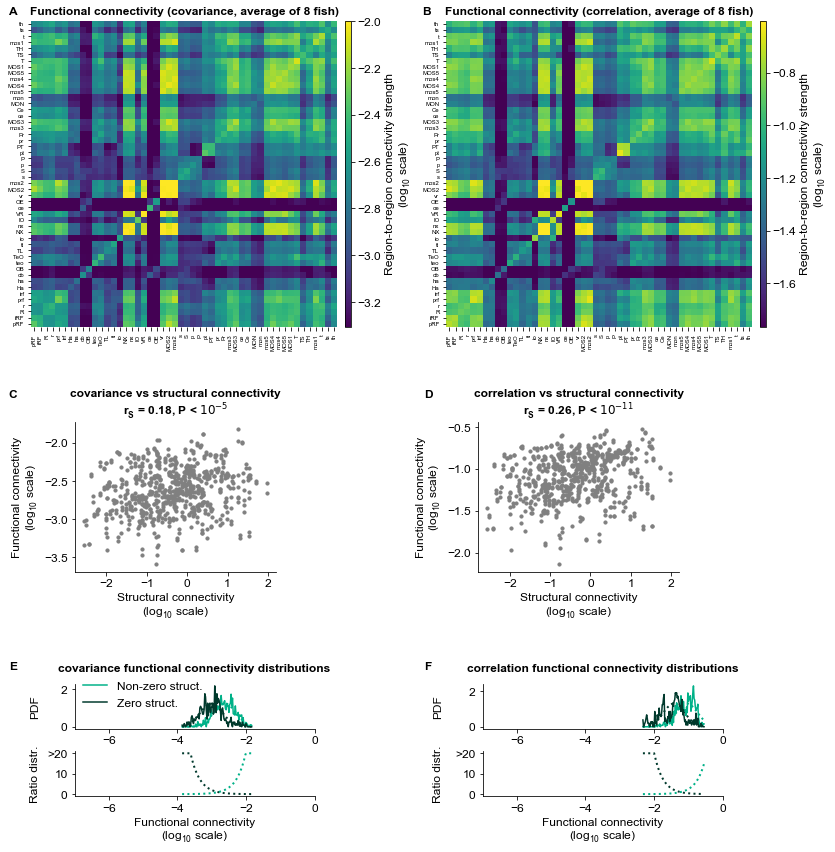

In [37]:
save_fig = True
selected_connectivity_type = 'my_new_normalized_by_volume'

fig = plt.figure(figsize=[12, 13])  # 12 , 9 
gs_matrices = fig.add_gridspec(ncols=2, nrows=1, left=0.05, right=0.9, top=0.95,
                               bottom=0.58, wspace=0.3, hspace=0)  # bottotm 45
gs_corr = fig.add_gridspec(ncols=2, nrows=1, left=0.1, right=0.8, top=0.5,
                               bottom=0.34, wspace=1, hspace=0)
gs_bottom = fig.add_gridspec(ncols=2, nrows=2, left=0.1, right=0.85, top=0.22, bottom=0.1,
                             wspace=0.7, hspace=0.5)
ax_covar = fig.add_subplot(gs_matrices[0])
ax_corr = fig.add_subplot(gs_matrices[1])

pf.plot_connectivity_matrix(matrix=all_averaged_functional_connectivities['method:covariance_agg:1'], # + 1e-6, #my_new_normalized_by_volume
                          cbar=True, plot_log=True, scale_limits=True,
                          region_names=region_names_baier, #mini=-4, maxi=-2,
                          region_order_dict=kunst_region_order, 
                          reverse_x=True, subset=subset, ax=ax_covar,
                           fill_zeros_with_min=False)
ax_covar.set_title(f'Functional connectivity (covariance, average of {len(runs)} fish)', 
                   fontdict={'weight': 'bold'})

_, region_names_use = pf.plot_connectivity_matrix(matrix=all_averaged_functional_connectivities['method:correlation_agg:1'], 
                          cbar=True, plot_log=True, #mini=-2, maxi=-0.5,
                            region_names=region_names_baier, size=5, scale_limits=True,
                          region_order_dict=kunst_region_order, 
                          reverse_x=True, subset=subset, ax=ax_corr)

ax_corr.set_title(f'Functional connectivity (correlation, average of {len(runs)} fish)', 
                 fontdict={'weight': 'bold'})

## Plot distr of funct connections of zero Baier vs nz Baier
struct_mat = all_baier_connectivities[selected_connectivity_type][subset, :][:, subset]  # subset = min # neurons in funct conn matrix



ax = {0: {}, 1: {}}
funct_nz, funct_zero = {}, {}
pdf_nz, pdf_zero = {}, {}
cdf_nz, cdf_zero = {}, {}
ax_comparison = {}

for i_plot, method in enumerate(['covariance', 'correlation']):
    ax[0][i_plot] = plt.subplot(gs_bottom[0, i_plot])
    ax[1][i_plot] = plt.subplot(gs_bottom[1, i_plot])
    funct_mat = all_averaged_functional_connectivities[f'method:{method}_agg:1'][subset, :][:, subset]
    assert np.sum(funct_mat == 0) == 0  # no zeros, so log scale doesn't throw any issues
    funct_mat = np.log10(funct_mat)  # show in log scale 
    
    pf.plot_zero_vs_nz_connectivity(ax_pdf=ax[0][i_plot], ax_cdf=ax[1][i_plot], funct_mat=funct_mat, 
                                    struct_mat=struct_mat,
                                    method=method,
                                    funct_nz=funct_nz, funct_zero=funct_zero, 
                                    pdf_nz=pdf_nz, pdf_zero=pdf_zero, 
                                    cdf_nz=cdf_nz, cdf_zero=cdf_zero, verbose=2,
                                    draw_pval=False, plot_evidence=True)
    
    ax_comparison[method] = fig.add_subplot(gs_corr[i_plot])
    pearson_corr, spearman_corr = pf.plot_funct_vs_struct(struct_mat=all_baier_connectivities[selected_connectivity_type],  # my_new_normalized_by_volume
                                    funct_mat=all_averaged_functional_connectivities[f'method:{method}_agg:1'],
                                        ax=ax_comparison[method], subset=subset, key=method, title='specific', compute_in_log=True,
                                                         fill_diag=False, filter_zeros=True, set_limits=True,
                                                         plot_in_log=True)

    ax[0][i_plot].set_ylabel('PDF');
    ax[1][i_plot].set_ylabel('Ratio distr.')
ax[0][0].legend(frameon=False, loc='upper left', bbox_to_anchor=(-0.01, 1.3))

ax_covar.text(s='A', x=53.2, y=-1.5, fontdict={'weight': 'bold', 'size': 12})
ax_corr.text(s='B', x=53.5, y=-1.5, fontdict={'weight': 'bold', 'size': 12})
# ax_covar.text(s='C', x=56, y=63.5, fontdict={'weight': 'bold', 'size': 12})
# ax_covar.text(s='D', x=9.5, y=63.5, fontdict={'weight': 'bold', 'size': 12})
# ax_covar.text(s='E', x=-32.2, y=63.5, fontdict={'weight': 'bold', 'size': 12})
ax_corr.text(s='D', x=53.2, y=61, fontdict={'weight': 'bold', 'size': 12})
ax_covar.text(s='C', x=53.2, y=61, fontdict={'weight': 'bold', 'size': 12})
ax_covar.text(s='E', x=53.2, y=105.5, fontdict={'weight': 'bold', 'size': 12})
ax_corr.text(s='F', x=53.2, y=105.5, fontdict={'weight': 'bold', 'size': 12})
fig.align_ylabels(axs=[ax_comparison['covariance'], ax[0][0], ax[1][0]])
fig.align_ylabels(axs=[ax_comparison['correlation'], ax[0][1], ax[1][1]])

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/sfig_connectivity_covar_corr.pdf', dpi=300)

In [188]:
kunst_region_order

{'inds': array([70, 71, 23, 22, 15, 14, 40, 41, 62, 63, 49, 46, 24, 20, 64, 68, 25,
        21,  3,  7, 34, 35, 17, 16,  9, 10, 11,  8, 12, 13, 45, 37, 61, 60,
        43, 42, 31, 30, 54, 55, 65, 69, 29, 28, 27, 26, 19, 18, 66, 67, 53,
        50, 57, 56, 33, 32, 59, 58,  2,  6,  0,  4, 51, 52,  1,  5, 39, 38,
        36, 44, 47, 48]),
 'names': array(['th', 'ts', 't', 'mos1', 'TH', 'TS', 'T', 'MOS1', 'MOS5', 'mos4',
        'MOS4', 'mos5', 'mon', 'MON', 'Ce', 'ce', 'MOS3', 'mos3', 'Pr',
        'pr', 'Hi', 'Nln', 'Hc', 'hc', 'hi', 'nln', 'Po', 'po', 'PT', 'pt',
        'P', 'p', 'S', 's', 'mos2', 'MOS2', 'vr', 'OG', 'TG', 'tg', 'gg',
        'GG', 'OE', 'oe', 'VR', 'og', 'IO', 'nx', 'NX', 'io', 'Ret', 'tl',
        'TL', 'ret', 'pit', 'Pit', 'Hr', 'hr', 'TeO', 'teo', 'OB', 'ob',
        'ha', 'Ha', 'irf', 'prf', 'r', 'R', 'iRF', 'pRF', 'arf', 'aRF'],
       dtype='<U4')}

In [194]:
assert len(region_names_baier) == 72
assert len(kunst_region_order['inds']) == 72
assert len(kunst_region_order['names']) == 72
assert len(kunst_region_abbrev_trans) == 72

In [213]:
# region_names_use
dict_region_names_table = {'Abbreviation': [], 'Full name': [], 'Abbreviation ': [], 'Full name ': []}
for i_abbrev in range(int(np.ceil(len(region_names_use) / 2))):
    abbrev = region_names_use[i_abbrev]
    dict_region_names_table['Abbreviation'].append(abbrev)
    dict_region_names_table['Full name'].append(kunst_region_abbrev_trans[abbrev].replace('_', ' '))
    abbrev2 = region_names_use[i_abbrev + int(np.ceil(len(region_names_use) / 2))]
    dict_region_names_table['Abbreviation '].append(abbrev2)
    dict_region_names_table['Full name '].append(kunst_region_abbrev_trans[abbrev2].replace('_', ' '))
pd.DataFrame(dict_region_names_table).to_latex('tmp.txt', index=False, 
                                               label='tab:kunstea_abbreviations',
                                               caption='Table of abbreviations of mapzebrain atlas region names (used for interregional connectivity analyses).')